# Imports and Dataset

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# Preprocessing

## Examining the Dataset

In [4]:
train.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  float64
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


In [10]:
train.nunique()

Employee ID             22750
Date of Joining           366
Gender                      2
Company Type                2
WFH Setup Available         2
Designation                 6
Resource Allocation        10
Mental Fatigue Score      101
Burn Rate                 101
dtype: int64

In [8]:
train.shape

(22750, 9)

In [11]:
train.isna().sum()

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64

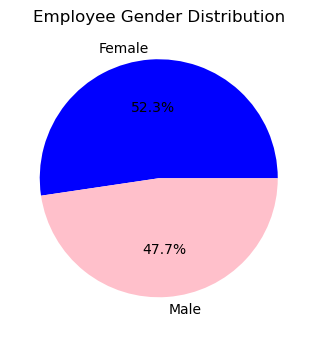

In [7]:
plt.subplot(1, 2, 2)
gender_counts = train['Gender'].value_counts()
colors = ['blue', 'pink']
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Employee Gender Distribution')

plt.show()

### Dropping Employee ID

The IDs of the employees don't provide useful information and therefore, they should be dropped.

In [16]:
train = train.drop(columns=['Employee ID'])


### One-Hot Encoding

Convert categorical data into a numerical format that machine learning models can understand.

- Gender
- Company Type
- WFH Setup Available

should be converted to binary values using this method.

Since these are nominal data without any inherent order, we can avoid introducing false ordinal relationships, which can lead to model bias and inaccurate predictions by using One-Hot encoding over Label Encoding.

In [17]:
# "Female" = 0, "Male" = 1
is_male = pd.get_dummies(train.Gender, drop_first=True)
# "Service" = 1, "Product" = 0
is_service = pd.get_dummies(train['Company Type'], drop_first=True)
# "Yes" = 1, "No" = 0
wfh_available = pd.get_dummies(train['WFH Setup Available'], drop_first=True)

In [18]:
for loc, column in enumerate(["is_male", "is_service", "wfh_available"], start=2):
    train.insert(loc=loc, column=column, value=eval(column))

train.drop(columns=["Gender", "Company Type", "WFH Setup Available"], axis=1, inplace=True)

In [19]:
is_male = pd.get_dummies(test.Gender, drop_first=True)
is_service = pd.get_dummies(test['Company Type'], drop_first=True)
wfh_available = pd.get_dummies(test['WFH Setup Available'], drop_first=True)

for loc, column in enumerate(["is_male", "is_service", "wfh_available"], start=2):
    test.insert(loc=loc, column=column, value=eval(column))

test.drop(columns=["Gender", "Company Type", "WFH Setup Available"], axis=1, inplace=True)

### Date of Joining

The date of joining doesn't seem to have a direct relationship with our target at first glance, but before discarding it, we should transform it into another numeric feature to analyze if it has any correlation with our target variable.

Min date 2008-01-01
Max date 2008-12-31


<Axes: xlabel='Month', ylabel='Hired employees'>

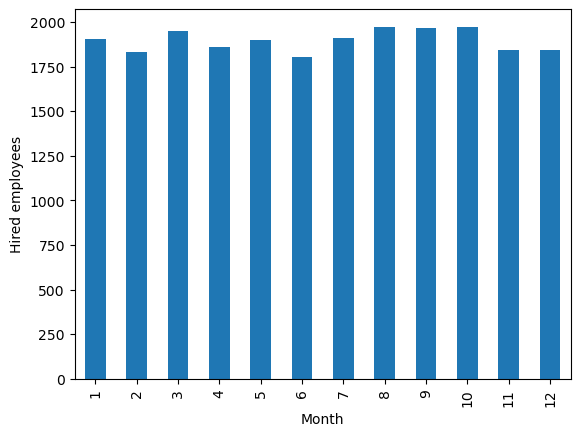

In [14]:
print(f"Min date {train['Date of Joining'].min()}")
print(f"Max date {train['Date of Joining'].max()}")
train_month = train.copy()

train_month['Date of Joining'] = train_month['Date of Joining'].astype("datetime64[ns]")
train_month['Date of Joining'].groupby(
    train_month['Date of Joining'].dt.month).count().plot(kind="bar", xlabel="Month", ylabel="Hired employees")

The date of joininig is uniformly distributed. In order to create a new feature which represents seniority, we could create a variables with the number of days worked. Since we don't have any information on when these observations were made, let's parse the date to the day of the year when the employees are hired.

In [15]:
dt_2008 = pd.to_datetime(["2008-01-01"]*len(train))
train['Days'] = train['Date of Joining'].astype("datetime64[ns]").sub(dt_2008).dt.days
train.Days

0        273
1        334
2         69
3        307
4        205
        ... 
22745    364
22746     18
22747    309
22748      9
22749      5
Name: Days, Length: 22750, dtype: int64

In [20]:
numeric_cols = train.select_dtypes(exclude='object').columns
correlations = train[numeric_cols].corr()['Burn Rate'].drop('Burn Rate')
print(correlations)

is_male                 0.154895
is_service              0.004281
wfh_available          -0.306266
Designation             0.737556
Resource Allocation     0.856278
Mental Fatigue Score    0.944546
Days                   -0.001358
Name: Burn Rate, dtype: float64


The day of the year the employee was hired doesn't have any correlation with out target. In this case, we will drop it.

In [24]:
train = train.drop(['Date of Joining', 'Days'], axis=1)
train.head().T

,0,1,2,3,4
is_male,False,True,False,True,False
is_service,True,True,False,True,True
wfh_available,False,True,True,True,False
Designation,2.0,1.0,2.0,1.0,3.0
Resource Allocation,3.0,2.0,NaN,1.0,7.0
Mental Fatigue Score,3.8,5.0,5.8,2.6,6.9
Burn Rate,0.16,0.36,0.49,0.2,0.52


### NaN Values

In [25]:
train.isna().sum()

is_male                    0
is_service                 0
wfh_available              0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64

There are NaN values on our target "Burn Rate". The other with NaN values seem to have an important relation with the target as well. Let's see by computing the perason correlation.


In [26]:
numeric_cols = train.select_dtypes(exclude='object').columns
correlations = train[numeric_cols].corr()['Burn Rate'].drop('Burn Rate')
print(correlations)

is_male                 0.154895
is_service              0.004281
wfh_available          -0.306266
Designation             0.737556
Resource Allocation     0.856278
Mental Fatigue Score    0.944546
Name: Burn Rate, dtype: float64


In [27]:
resource_nan = train['Resource Allocation'].isna()
mental_nan = train['Mental Fatigue Score'].isna()
burnrate_nan = train['Burn Rate'].isna()

# Values with no Burn Rate & Mental Fatigue Score
train[(burnrate_nan) & (mental_nan)]

,is_male,is_service,wfh_available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
45,True,True,True,2.0,3.0,NaN,NaN
47,False,False,True,3.0,6.0,NaN,NaN
122,False,False,False,3.0,5.0,NaN,NaN
127,True,True,False,3.0,5.0,NaN,NaN
135,False,True,True,1.0,4.0,NaN,NaN
...,...,...,...,...,...,...,...
21507,True,True,False,2.0,4.0,NaN,NaN
21701,True,False,True,2.0,4.0,NaN,NaN
21888,True,True,False,3.0,6.0,NaN,NaN
21937,True,True,False,3.0,6.0,NaN,NaN


In [30]:
# Drop rows with missing target values
missing_target_rows = train.loc[train['Burn Rate'].isna(), :].index
train = train.drop(missing_target_rows, axis=0).reset_index(drop=True)

In [31]:
train.isna().sum()

is_male                    0
is_service                 0
wfh_available              0
Designation                0
Resource Allocation     1278
Mental Fatigue Score    1945
Burn Rate                  0
dtype: int64

We can roughtly predict the **Mental Fatigue Score** by **Burn Rate**.

In [32]:
# Mask for rows where both burnrate_nan and mental_nan are True
double_nan_indices = train[(burnrate_nan) & (mental_nan)].index

# Drop rows where both features are missing, but keep partial rows where one of them exists
train.drop(index=double_nan_indices, axis=0, inplace=True)
# Reset DataFrame index so it's sequential again
train.reset_index(drop=True, inplace=True)
# Cleanup memory
del double_nan_indices, is_male, is_service, wfh_available

/var/folders/_t/qqzcs1n516j9ncqxkt1b835r0000gn/T/ipykernel_96514/3578506603.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  double_nan_indices = train[(burnrate_nan) & (mental_nan)].index


In [33]:
train.isna().sum()

is_male                    0
is_service                 0
wfh_available              0
Designation                0
Resource Allocation     1267
Mental Fatigue Score    1933
Burn Rate                  0
dtype: int64

### Check Correlations

We want to check the correlations of variables to guide:
- Feature Selection
- Imputation Strategy
- Model Interpretability

In [34]:
train_corr = train.corr()
train_corr['Burn Rate'].sort_values(ascending=False)
train_corr = train_corr.drop(columns='Burn Rate')

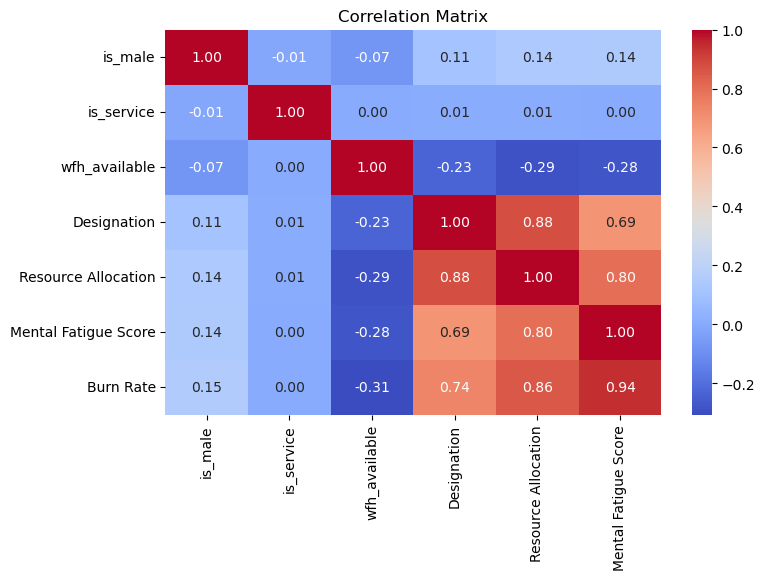

In [35]:
plt.figure(figsize=(8,5))
sns.heatmap(data=train_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.yticks(rotation=0)
plt.show()


There exists very high correlation between some of the variables. We shall take a look at some of them.

#### Mental Fatigue Score and Burn Rate

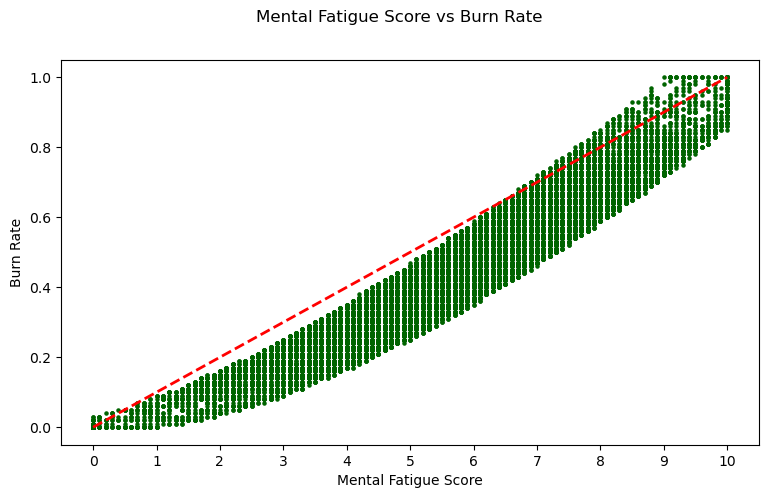

In [65]:
plt.figure(figsize=(9, 5))
plt.scatter("Mental Fatigue Score", "Burn Rate", data=train, s=5, c="darkgreen")
plt.plot([0,10], [0,1], linewidth=2, c="red", linestyle='--')
plt.xlabel("Mental Fatigue Score")
plt.ylabel("Burn Rate")
plt.suptitle('Mental Fatigue Score vs Burn Rate')
plt.xticks(range(0,11))
plt.show()

#### Resource Allocation and Burn Rate

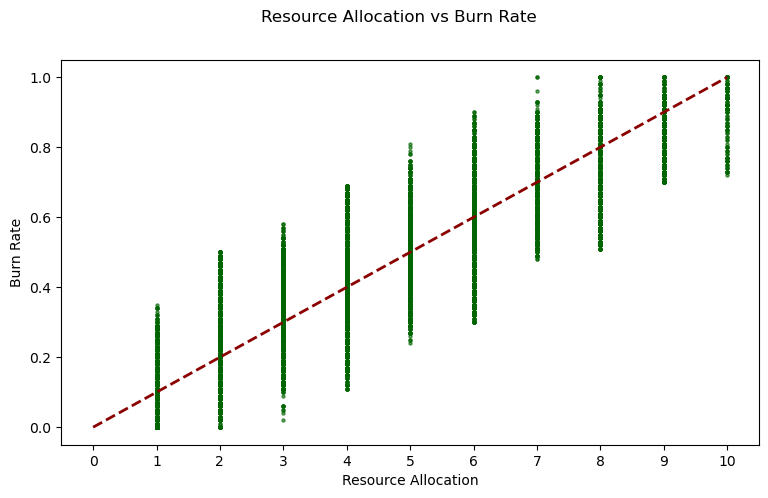

In [78]:
plt.figure(figsize=(9, 5))
plt.scatter("Resource Allocation", "Burn Rate", alpha=0.6, data=train, s=5, c="darkgreen")
plt.plot([0,10], [0,1], linewidth=2, c="darkred", linestyle='--')
plt.xlabel("Resource Allocation")
plt.ylabel("Burn Rate")
plt.suptitle('Resource Allocation vs Burn Rate')
plt.xticks(range(0,11))
plt.show()

To prevent noise when filling in the missing values, we should interpolate the data by:
- Creating a copy of the dataset with non-null **Mental Fatigue Score** and **Burn Rate** values
- Bake the interpolation function
- Predict the NaN values by the function and replace them with the new values

In [69]:
describe_original = train.describe()
describe_original

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,21458.000000,20191.000000,19525.000000,21458.000000
mean,2.179420,4.484671,5.730064,0.452021
std,1.135119,2.048580,1.920670,0.198266
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.320000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


In [70]:
from scipy import interpolate
# Create the copy of our dataset and make sure there are no NaN values in MFS and Burn Rate
train_copy = train.copy(deep=True)

mental_not_na = train_copy['Mental Fatigue Score'].notna()
burn_not_na = train_copy['Burn Rate'].notna()

train_copy = train_copy[(mental_not_na) & (burn_not_na)]
del mental_not_na, burn_not_na

In [71]:
# Function to interpolate Mental Fatigue Score from a known Burn Rate
fn_mental = interpolate.interp1d(y=train_copy['Mental Fatigue Score'],
                                 x=train_copy['Burn Rate'],
                                 kind="linear",
                                 fill_value=None)

In [72]:
# Get rid of NaNs by calling the interpolation functions
for i in train[train['Mental Fatigue Score'].isna()].index:
    train.loc[i, 'Mental Fatigue Score'] =  fn_mental(train.loc[i, 'Burn Rate'])

In [73]:
train.isna().sum()

is_male                    0
is_service                 0
wfh_available              0
Designation                0
Resource Allocation     1267
Mental Fatigue Score       0
Burn Rate                  0
dtype: int64

**Resource Allocation** is also highly correlated with **Designation**.

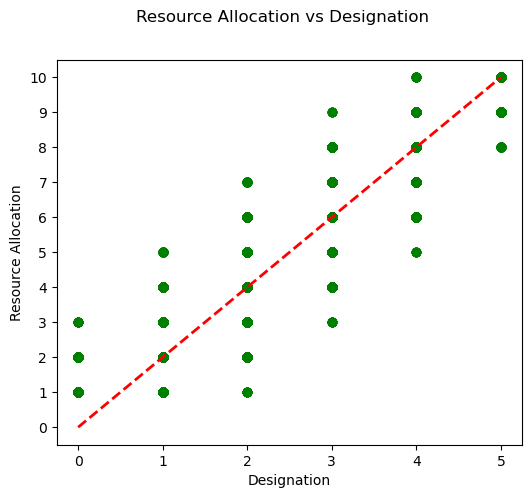

In [83]:
plt.figure(figsize=(6, 5))
plt.scatter('Designation', 'Resource Allocation', data=train, c='green')
plt.plot([0,5], [0,10], linewidth=2, c="red", linestyle='--')
plt.xlabel('Designation')
plt.ylabel('Resource Allocation')
plt.suptitle('Resource Allocation vs Designation')
plt.yticks(range(0,11))
plt.show()

### Group-wise Imputation

We will get the mean value for each **Designation** group and fill in the missing values in the **Resource Allocation** column based on the mean value.

In [84]:
for i in range(6):      # 0 to 5, Designation values
    mean_value = train['Resource Allocation'][train['Designation']==i].mean()

    # Build a condition mask for all rows where Designation == i AND Resource Allocation is NaN
    condition = (train['Designation']==i) & (train['Resource Allocation'].isna())

    # Fill in NaN values with group-specific mean
    train.loc[condition, 'Resource Allocation'] = mean_value

del train_copy, fn_mental

In [85]:
train.isna().sum()

is_male                 0
is_service              0
wfh_available           0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
Burn Rate               0
dtype: int64

### Handle Outliers

In [88]:
from scipy import stats

def outlier_analysis(df):
    
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    outlier_summary = []
    
    fig, axes = plt.subplots(2, len(numerical_cols), figsize=(4*len(numerical_cols), 8))
    fig.suptitle('Outlier Detection', fontsize=16, fontweight='bold')
    
    if len(numerical_cols) == 1:
        axes = axes.reshape(-1, 1)
    
    for i, col in enumerate(numerical_cols):
        data = df[col].dropna()
        
        # IQR method
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_iqr = data[(data < lower_bound) | (data > upper_bound)]
        
        # Z-score method
        z_scores = np.abs(stats.zscore(data))
        outliers_zscore = data[z_scores > 3]
        
        outlier_summary.append({
            'Feature': col,
            'IQR_Outliers': len(outliers_iqr),
            'IQR_Percentage': len(outliers_iqr) / len(data) * 100,
            'ZScore_Outliers': len(outliers_zscore),
            'ZScore_Percentage': len(outliers_zscore) / len(data) * 100
        })
        
        # Box plot
        axes[0, i].boxplot(data)
        axes[0, i].set_title(f'{col}\nIQR: {len(outliers_iqr)} outliers')
        axes[0, i].set_ylabel('Value')
        
        # Histogram with outlier boundaries
        axes[1, i].hist(data, bins=30, alpha=0.7, color='lightblue')
        axes[1, i].axvline(lower_bound, color='red', linestyle='--', label='Lower bound')
        axes[1, i].axvline(upper_bound, color='red', linestyle='--', label='Upper bound')
        axes[1, i].set_title(f'{col}\nZ-score: {len(outliers_zscore)} outliers')
        axes[1, i].set_xlabel('Value')
        axes[1, i].set_ylabel('Frequency')
        axes[1, i].legend()
    
    plt.tight_layout()
    plt.show()

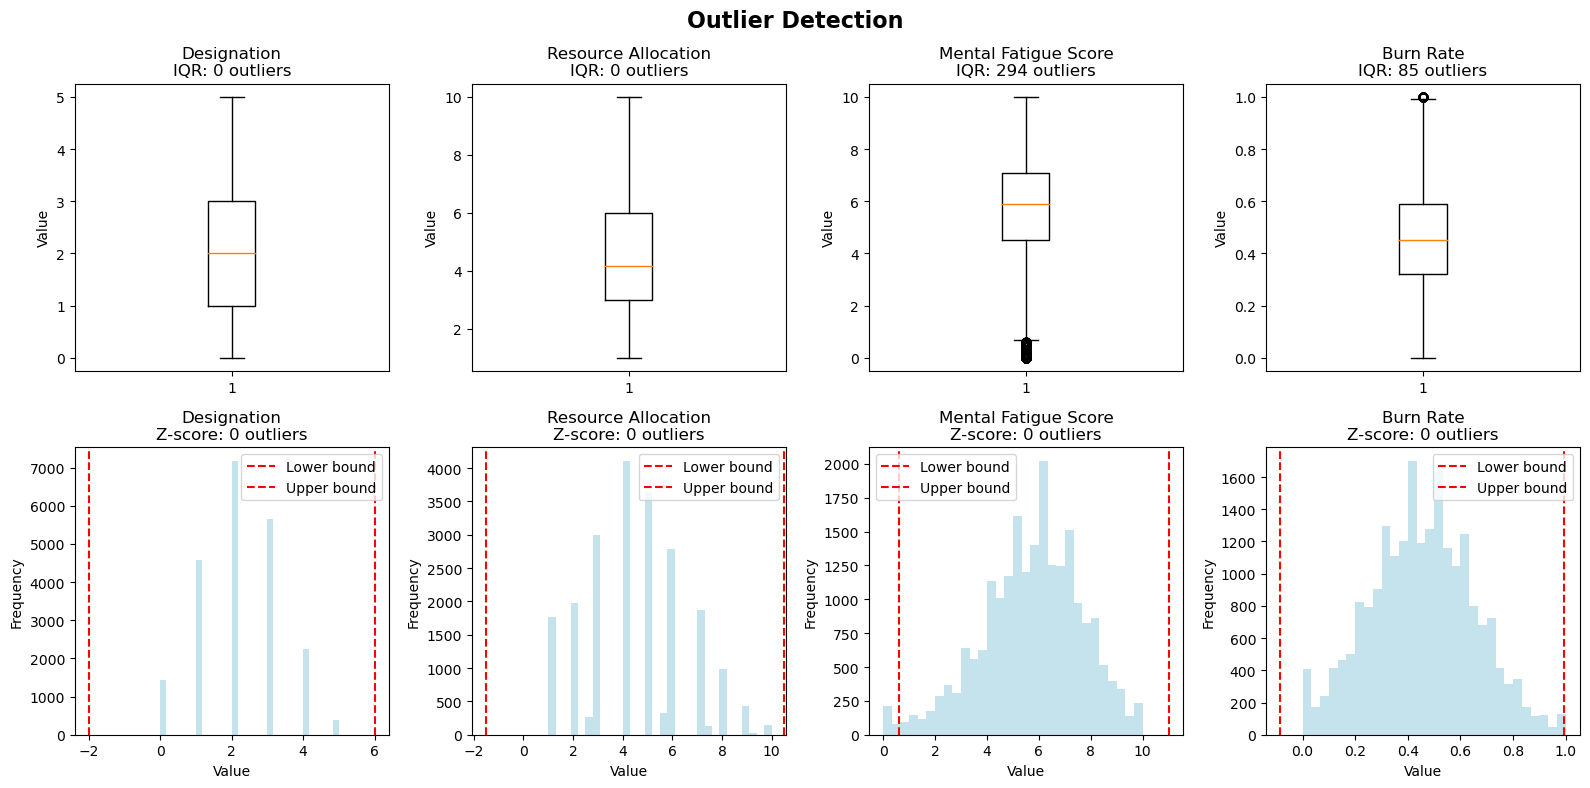

In [89]:
outlier_analysis(train)

In [96]:
burn_outliers = train[train['Burn Rate'] >= 1.0]
burn_outliers

,is_male,is_service,wfh_available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
396,False,True,False,5.0,10.000000,10.0,1.0
581,False,False,True,5.0,9.182336,9.4,1.0
685,False,True,False,4.0,9.000000,9.3,1.0
828,False,False,True,4.0,8.000000,10.0,1.0
1176,True,True,False,5.0,10.000000,9.4,1.0
...,...,...,...,...,...,...,...
20161,False,False,False,5.0,10.000000,9.2,1.0
20342,False,True,False,5.0,10.000000,9.9,1.0
21036,True,True,False,5.0,9.000000,10.0,1.0
21312,True,False,True,5.0,10.000000,10.0,1.0


In [97]:
def remove_outliers(df, method='iqr'):
    """Remove outliers using IQR method by capping them"""
    df_clean = df.copy()
    numeric_cols = ['Resource Allocation', 'Mental Fatigue Score', 'Burn Rate']
    
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = ((train[col] < lower_bound) | (train[col] > upper_bound)).sum()
        print(f"{col}: {outliers} outliers detected")
        
        # Cap outliers instead of removing to preserve data
        df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)
    
    return df_clean

# Apply outlier treatment to continuous variables
continuous_cols = ['Resource Allocation', 'Mental Fatigue Score']


train_clean = remove_outliers(train)
print("Outlier treatment completed.")

Resource Allocation: 0 outliers detected
Mental Fatigue Score: 294 outliers detected
Burn Rate: 85 outliers detected
Outlier treatment completed.


#### Original Data

In [98]:
display(describe_original.iloc[:3, -3:])

,Resource Allocation,Mental Fatigue Score,Burn Rate
count,20191.000000,19525.000000,21458.000000
mean,4.484671,5.730064,0.452021
std,2.048580,1.920670,0.198266


#### Cleaned Data

In [101]:
describe_botox = train.describe()
display(describe_botox.iloc[:3, -3:])

,Resource Allocation,Mental Fatigue Score,Burn Rate
count,21458.000000,21458.000000,21458.000000
mean,4.483679,5.716642,0.452021
std,2.033964,1.925369,0.198266


## Scale Numeric Features

In [104]:
from sklearn.preprocessing import StandardScaler
numeric_cols = ['Designation', 'Resource Allocation', 'Mental Fatigue Score']
scaler = StandardScaler()

train_scaled = train.copy()
train_scaled[numeric_cols] = scaler.fit_transform(train[numeric_cols])

In [105]:
train.head()

,is_male,is_service,wfh_available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,False,True,False,2.0,3.000000,3.8,0.16
1,True,True,True,1.0,2.000000,5.0,0.36
2,False,False,True,2.0,4.183048,5.8,0.49
3,True,True,True,1.0,1.000000,2.6,0.20
4,False,True,False,3.0,7.000000,6.9,0.52


# Training & Validation

## Data Preparation

In [106]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error as mae, r2_score
from statsmodels.tools.eval_measures import mse, rmse
# Split data using cleaned dataset with better parameters
X_train, X_val, y_train, y_val = train_test_split(
    train_scaled.iloc[:, :-1],  # Use cleaned data
    train_scaled.iloc[:, -1],    # Target variable
    test_size=0.2,              # Reduced validation size for more training data
    shuffle=True,
    random_state=42             # Fixed seed for reproducibility
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Features: {X_train.columns.tolist()}")

Training set shape: (17166, 6)
Validation set shape: (4292, 6)
Features: ['is_male', 'is_service', 'wfh_available', 'Designation', 'Resource Allocation', 'Mental Fatigue Score']


## XGBoost Regressor

In [107]:
import xgboost as xgb
import optuna

In [108]:
from sklearn.model_selection import KFold

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'early_stopping_rounds': 50,
        'random_state': 42
    }

    # Use more sophisticated cross-validation with more folds
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, valid_idx in kf.split(X_train):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = xgb.XGBRegressor(**params)
        model.fit(
            X_t, y_t,
            eval_set=[(X_v, y_v)],
            verbose=False
        )

        y_pred = model.predict(X_v)
        scores.append(r2_score(y_v, y_pred))

    return np.mean(scores)

In [109]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  

print("Best hyperparameters:")
print(study.best_params)
print(f"Best R² score: {study.best_value:.4f}")

[I 2025-09-04 00:33:35,952] A new study created in memory with name: no-name-58e93e4a-9c2b-45cb-bf3e-dbb45505d488
[I 2025-09-04 00:33:36,867] Trial 0 finished with value: 0.9294836026209511 and parameters: {'max_depth': 6, 'learning_rate': 0.0992844553670298, 'n_estimators': 981, 'subsample': 0.988717059987654}. Best is trial 0 with value: 0.9294836026209511.
[I 2025-09-04 00:33:39,275] Trial 1 finished with value: 0.9284156503877983 and parameters: {'max_depth': 8, 'learning_rate': 0.02072287078659231, 'n_estimators': 877, 'subsample': 0.9106008503677615}. Best is trial 0 with value: 0.9294836026209511.
[I 2025-09-04 00:33:40,123] Trial 2 finished with value: 0.9293616871793621 and parameters: {'max_depth': 4, 'learning_rate': 0.11894083675017253, 'n_estimators': 839, 'subsample': 0.8418854742945571}. Best is trial 0 with value: 0.9294836026209511.
[I 2025-09-04 00:33:41,249] Trial 3 finished with value: 0.9282626680185369 and parameters: {'max_depth': 8, 'learning_rate': 0.0823042113

Best hyperparameters:
{'max_depth': 5, 'learning_rate': 0.048566210132247586, 'n_estimators': 514, 'subsample': 0.9058070433151373}
Best R² score: 0.9296


In [120]:
# --- Tuned Model ---
best_xgb_params = study.best_trial.params
best_xgb = xgb.XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    booster="gbtree",
    **best_xgb_params
)
best_xgb.fit(X_train, y_train)
xgb_tuned_preds = best_xgb.predict(X_val)

# --- Un-tuned Model ---
xgb_default = xgb.XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    booster="gbtree",
    random_state=42
)
xgb_default.fit(X_train, y_train)
xgb_default_preds = xgb_default.predict(X_val)

print("XGB Tuned R²:", r2_score(y_val, xgb_tuned_preds))
print("XGB Default R²:", r2_score(y_val, xgb_default_preds))
print("Improvement:", r2_score(y_val, xgb_tuned_preds) - r2_score(y_val, xgb_default_preds))

XGB Tuned R²: 0.9260558426873056
XGB Default R²: 0.9247195684424728
Improvement: 0.0013362742448327358


## Random Forest Regressor

In [110]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
import time

In [111]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth':  trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, valid_idx in kf.split(X_train):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = RandomForestRegressor(**params)
        model.fit(X_t, y_t)
        y_pred = model.predict(X_v)
        scores.append(r2_score(y_v, y_pred))

    return np.mean(scores)

In [112]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50)
print("Best hyperparameters (RF):", study_rf.best_params)
print(f"Best R² score (RF): {study_rf.best_value:.4f}")

[I 2025-09-04 00:34:54,848] A new study created in memory with name: no-name-fe145705-fafc-4226-9692-b38ae46d1205
[I 2025-09-04 00:34:56,344] Trial 0 finished with value: 0.9256004608484663 and parameters: {'n_estimators': 238, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.9256004608484663.
[I 2025-09-04 00:35:03,363] Trial 1 finished with value: 0.9174135162707774 and parameters: {'n_estimators': 990, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.9256004608484663.
[I 2025-09-04 00:35:07,873] Trial 2 finished with value: 0.9272285219149008 and parameters: {'n_estimators': 925, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 0.9272285219149008.
[I 2025-09-04 00:35:11,287] Trial 3 finished with value: 0.926445393080922

Best hyperparameters (RF): {'n_estimators': 827, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': True}
Best R² score (RF): 0.9280


In [122]:
# --- Tuned Model ---
best_rf_params = study_rf.best_trial.params
best_rf = RandomForestRegressor(
    **best_rf_params,
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train, y_train)
rf_tuned_preds = best_rf.predict(X_val)

# --- Un-tuned Model ---
rf_default = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_default.fit(X_train, y_train)
rf_default_preds = rf_default.predict(X_val)

print("RF Tuned R²:", r2_score(y_val, rf_tuned_preds))
print("RF Default R²:", r2_score(y_val, rf_default_preds))
print("Improvement:", r2_score(y_val, rf_tuned_preds) - r2_score(y_val, rf_default_preds))

RF Tuned R²: 0.9254219830371455
RF Default R²: 0.9127709878711514
Improvement: 0.012650995165994106


## Decision Tree Regressor

In [113]:
from sklearn.tree import DecisionTreeRegressor

In [114]:
def objective_dt(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, valid_idx in kf.split(X_train):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = DecisionTreeRegressor(**params)
        model.fit(X_t, y_t)
        y_pred = model.predict(X_v)
        scores.append(r2_score(y_v, y_pred))

    return np.mean(scores)

In [115]:
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective_dt, n_trials=50)
print("Best hyperparameters (DT):", study_dt.best_params)
print(f"Best R² score (DT): {study_dt.best_value:.4f}")

[I 2025-09-04 00:44:16,991] A new study created in memory with name: no-name-14a12f45-6d53-4db1-86d3-fed64bdbd371
[I 2025-09-04 00:44:17,041] Trial 0 finished with value: 0.8888222701751649 and parameters: {'max_depth': 7, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.8888222701751649.
[I 2025-09-04 00:44:17,160] Trial 1 finished with value: 0.9106249700461551 and parameters: {'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9106249700461551.
[I 2025-09-04 00:44:17,236] Trial 2 finished with value: 0.8083613347638512 and parameters: {'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.9106249700461551.
[I 2025-09-04 00:44:17,323] Trial 3 finished with value: 0.9238824432480912 and parameters: {'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 3 

Best hyperparameters (DT): {'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': None}
Best R² score (DT): 0.9247


In [124]:
# --- Tuned Model ---
best_dt_params = study_dt.best_trial.params
best_dt = DecisionTreeRegressor(
    **best_dt_params,
    random_state=42
)
best_dt.fit(X_train, y_train)
dt_tuned_preds = best_dt.predict(X_val)

# --- Un-tuned Model ---
dt_default = DecisionTreeRegressor(random_state=42)
dt_default.fit(X_train, y_train)
dt_default_preds = dt_default.predict(X_val)

print("DT Tuned R²:", r2_score(y_val, dt_tuned_preds))
print("DT Default R²:", r2_score(y_val, dt_default_preds))
print("Improvement:", r2_score(y_val, dt_tuned_preds) - r2_score(y_val, dt_default_preds))

DT Tuned R²: 0.9217258216111072
DT Default R²: 0.9020586870804234
Improvement: 0.019667134530683805


## Model Comparison

### Collect All Tuned Models

In [154]:
models = {
    'XGBoost': best_xgb_model,
    'Random Forest': best_rf,
    'Decision Tree': best_dt,
}

model_params = {
    'XGBoost': study.best_params,
    'Random Forest': best_rf_params,
    'Decision Tree': best_dt_params
}   

### Evaluate on Validation Set

In [131]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [128]:
def evaluate_model(model, X_val, y_val, model_name):
    predictions = model.predict(X_val)

    r2 = r2_score(y_val, predictions)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    mae = mean_absolute_error(y_val, predictions)

    # Calculate residuals
    residuals = y_val - predictions

    return {
        'model': model_name,
        'r2_score': r2,
        'rmse': rmse,
        'mae': mae,
        'predictions': predictions,
        'residuals': residuals
    }

In [142]:
print("===Validation Set Evaluation===")
validation_results = {}

for name, model in models.items():
    result = evaluate_model(model, X_val, y_val, name)
    validation_results[name] = result

    print(f"\n{name} Performance:")
    print(f"  R² Score: {result['r2_score']:.4f}")
    print(f"  RMSE: {result['rmse']:.4f}")
    print(f"  MAE: {result['mae']:.4f}")

metrics_df = pd.DataFrame([{
    'Model': name,
    'R² Score': res['r2_score'],
    'RMSE': res['rmse'],
    'MAE': res['mae']
    } for name, res in validation_results.items()])

===Validation Set Evaluation===

XGBoost Performance:
  R² Score: 0.9261
  RMSE: 0.0535
  MAE: 0.0432

Random Forest Performance:
  R² Score: 0.9254
  RMSE: 0.0537
  MAE: 0.0436

Decision Tree Performance:
  R² Score: 0.9217
  RMSE: 0.0550
  MAE: 0.0445


In [133]:
def create_comparison_table(results):
    comparison_data = []

    for name, result in results.items():
        comparison_data.append({ 
            'Model': name,
            'R² Score': result['r2_score'],
            'RMSE': result['rmse'],
            'MAE': result['mae']
    })

    df_comparison = pd.DataFrame(comparison_data)
    df_comparison = df_comparison.sort_values('R² Score', ascending=False)

    return df_comparison


comparison_df = create_comparison_table(validation_results)
print("\n=== MODEL COMPARISON TABLE ===")
print(comparison_df.round(4))

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = models[best_model_name]
print(f"Best Model: {best_model_name}")


=== MODEL COMPARISON TABLE ===
           Model  R² Score    RMSE     MAE
0        XGBoost    0.9261  0.0535  0.0432
1  Random Forest    0.9254  0.0537  0.0436
2  Decision Tree    0.9217  0.0550  0.0445
Best Model: XGBoost


/var/folders/_t/qqzcs1n516j9ncqxkt1b835r0000gn/T/ipykernel_96514/621773546.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="R² Score", data=metrics_df, palette="viridis")


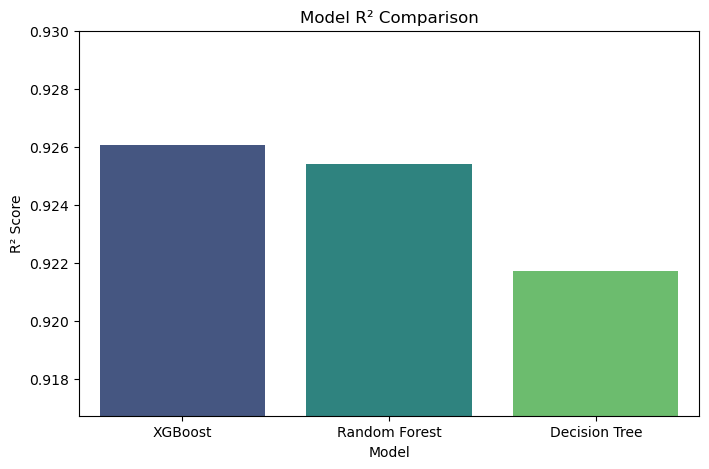

In [150]:
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="R² Score", data=metrics_df, palette="viridis")
plt.ylim(metrics_df["R² Score"].min() - 0.005, .93) # Zoom in
plt.title("Model R² Comparison")
plt.show()

In [193]:
xgb_preds_full = best_xgb.predict(X_val)
errors = abs(y_val - xgb_preds_full)

# Best 3 indices
best_idx = errors.nsmallest(3).index

# 2 random indices from the rest
remaining_idx = errors.drop(best_idx).sample(2, random_state=42).index

# Combine
sample_idx = best_idx.union(remaining_idx)

X_sample = X_val.loc[sample_idx]
y_actual = y_val.loc[sample_idx]

xgb_y_pred = best_xgb.predict(X_sample)
rf_y_pred = best_rf.predict(X_sample)
dt_y_pred = best_dt.predict(X_sample)

comparison_df = pd.DataFrame({
    'Actual Burn Rate': y_actual,
    'XGBoost Predicted': xgb_y_pred,
    'Random Forest Predicted': rf_y_pred,
    'Decision Tree Predicted': dt_y_pred,
}, index=sample_idx)

print(comparison_df)

       Actual Burn Rate  XGBoost Predicted  Random Forest Predicted  \
6682               0.79           0.663651                 0.664190   
9620               0.43           0.380597                 0.385925   
5567               0.36           0.353603                 0.354581   
10504              0.28           0.235394                 0.237895   
15123              0.17           0.234934                 0.235657   

       Decision Tree Predicted  
6682                  0.652500  
9620                  0.370333  
5567                  0.345789  
10504                 0.244848  
15123                 0.238919  


## Test Case: Pick Random Samples from Validation Split

In [198]:
import numpy as np
import pandas as pd

def filter_samples(X_val, y_val, best_xgb, best_rf, best_dt, n=5, tolerance=0.02):
    
    # Predictions
    xgb_preds = best_xgb.predict(X_val)
    rf_preds = best_rf.predict(X_val)
    dt_preds = best_dt.predict(X_val)

    # Errors
    xgb_err = abs(y_val - xgb_preds)
    rf_err = abs(y_val - rf_preds)
    dt_err = abs(y_val - dt_preds)

    # Create comparison DataFrame
    comparison = pd.DataFrame({
        'Actual Burn Rate': y_val,
        'XGBoost Predicted': xgb_preds,
        'Random Forest Predicted': rf_preds,
        'Decision Tree Predicted': dt_preds,
        'XGB Error': xgb_err,
        'RF Error': rf_err,
        'DT Error': dt_err
    })

    # Filter: all models decent, but XGB best
    mask = (
        (rf_err < tolerance) &
        (dt_err < tolerance) &
        (xgb_err < rf_err) &
        (xgb_err < dt_err) &
        (xgb_err > 0.01) &   
        (xgb_err < 0.05)    

    )
    candidates = comparison[mask]

    # Pick n samples
    if len(candidates) >= n:
        return candidates.nsmallest(n, 'XGB Error')
    else:
        # fallback: return all candidates if fewer than n
        return candidates

candidate_rows = filter_samples(X_val, y_val, best_xgb, best_rf, best_dt, n=5, tolerance=0.05)
print(candidate_rows.head(10))

       Actual Burn Rate  XGBoost Predicted  Random Forest Predicted  \
12762              0.42           0.410000                 0.409596   
16593              0.53           0.519960                 0.504535   
4914               0.18           0.169894                 0.164265   
13741              0.38           0.390435                 0.390788   
4510               0.12           0.130510                 0.133572   

       Decision Tree Predicted  XGB Error  RF Error  DT Error  
12762                 0.395000   0.010000  0.010404  0.025000  
16593                 0.494231   0.010040  0.025465  0.035769  
4914                  0.161905   0.010106  0.015735  0.018095  
13741                 0.403913   0.010435  0.010788  0.023913  
4510                  0.132083   0.010510  0.013572  0.012083  


In [199]:
# Randomly pick n rows for presentation
presentation_df = candidate_rows.drop(columns=['XGB Error', 'RF Error', 'DT Error'])
presentation_df = presentation_df.sample(5, random_state=42)

print(presentation_df)

       Actual Burn Rate  XGBoost Predicted  Random Forest Predicted  \
16593              0.53           0.519960                 0.504535   
4510               0.12           0.130510                 0.133572   
4914               0.18           0.169894                 0.164265   
12762              0.42           0.410000                 0.409596   
13741              0.38           0.390435                 0.390788   

       Decision Tree Predicted  
16593                 0.494231  
4510                  0.132083  
4914                  0.161905  
12762                 0.395000  
13741                 0.403913  


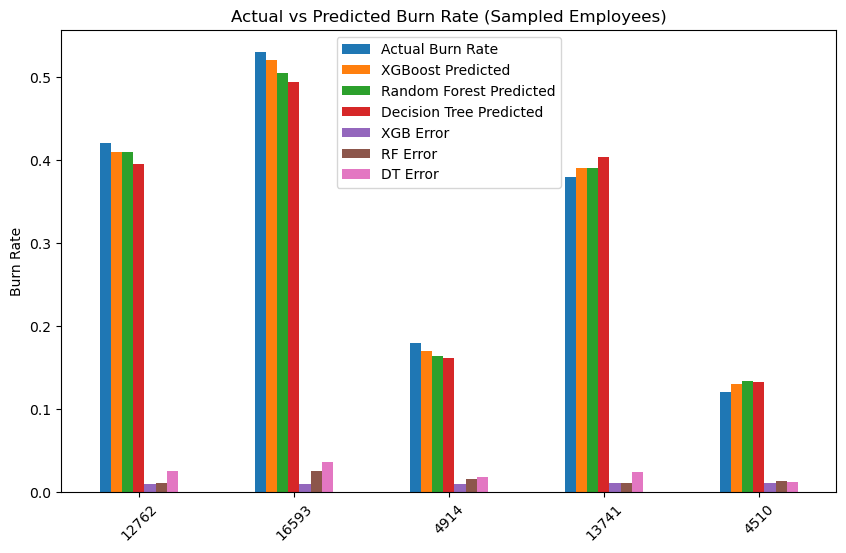

In [197]:
comparison_df['XGB Error'] = abs(comparison_df['XGBoost Predicted'] - comparison_df['Actual Burn Rate'])
comparison_df['RF Error'] = abs(comparison_df['Random Forest Predicted'] - comparison_df['Actual Burn Rate'])
comparison_df['DT Error'] = abs(comparison_df['Decision Tree Predicted'] - comparison_df['Actual Burn Rate'])

comparison_df.plot(kind='bar', figsize=(10,6))
plt.title("Actual vs Predicted Burn Rate (Sampled Employees)")
plt.ylabel("Burn Rate")
plt.xticks(rotation=45)
plt.show()



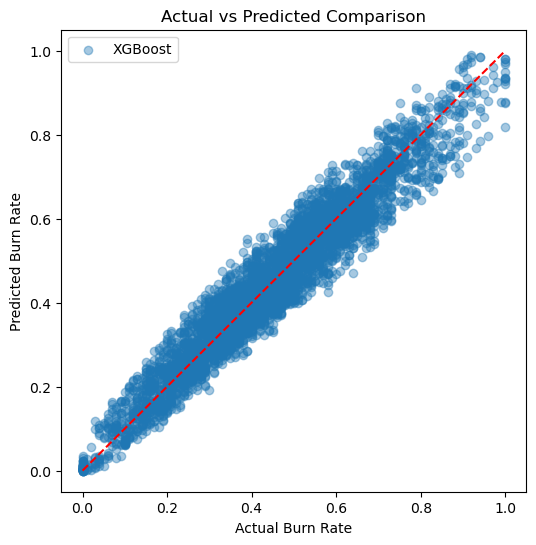

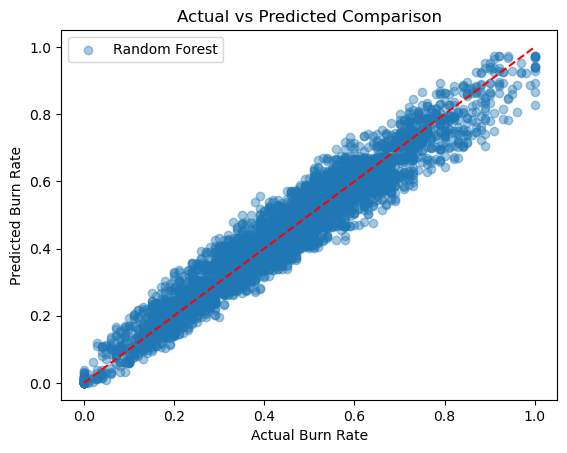

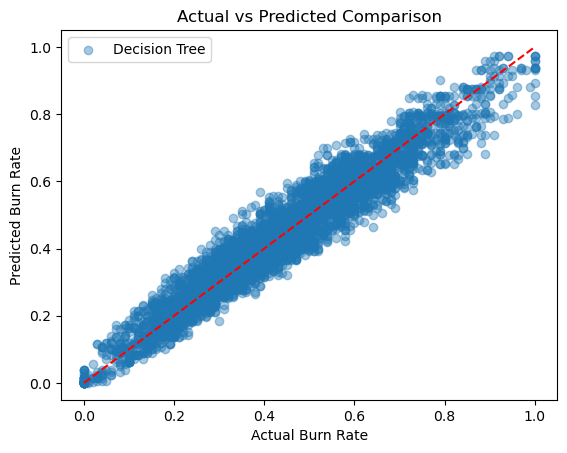

In [202]:
plt.figure(figsize=(6,6))
for name, res in validation_results.items():
    plt.scatter(y_val, res['predictions'], alpha=0.4, label=name)
    
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel("Actual Burn Rate")
    plt.ylabel("Predicted Burn Rate")
    plt.title("Actual vs Predicted Comparison")
    plt.legend()
    plt.show()


